Get the data

In [1]:
import os
import pandas as pd
import numpy as np

# Import charting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings thrown by Seaborn
import warnings
warnings.filterwarnings('ignore')

def load_titanic_data(filename, folder="Data"):
    csv_path = os.path.join(folder, filename)
    return pd.read_csv(csv_path)

titanic_train = load_titanic_data("train.csv")
titanic_test = load_titanic_data("test.csv")

titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


So initial lessons to learn: Age has over 150 missing values which is significant in this dataset size Cabin has 22% population which is very poor could initially transform into a new column of has cabin which is binary, not sure if a location from cabin can be gleaned to help predict survival rates based on where in the ship passengers had cabins? Maybe those with cabins could be more likely to have been in them at the time of sinking?

Need to remove PassengerId from training process

Only numerical fields which are related numerical - age and fare. The rest are categorical

In [3]:
204/891 * 100 #Cabin population rate

22.895622895622896

In [4]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


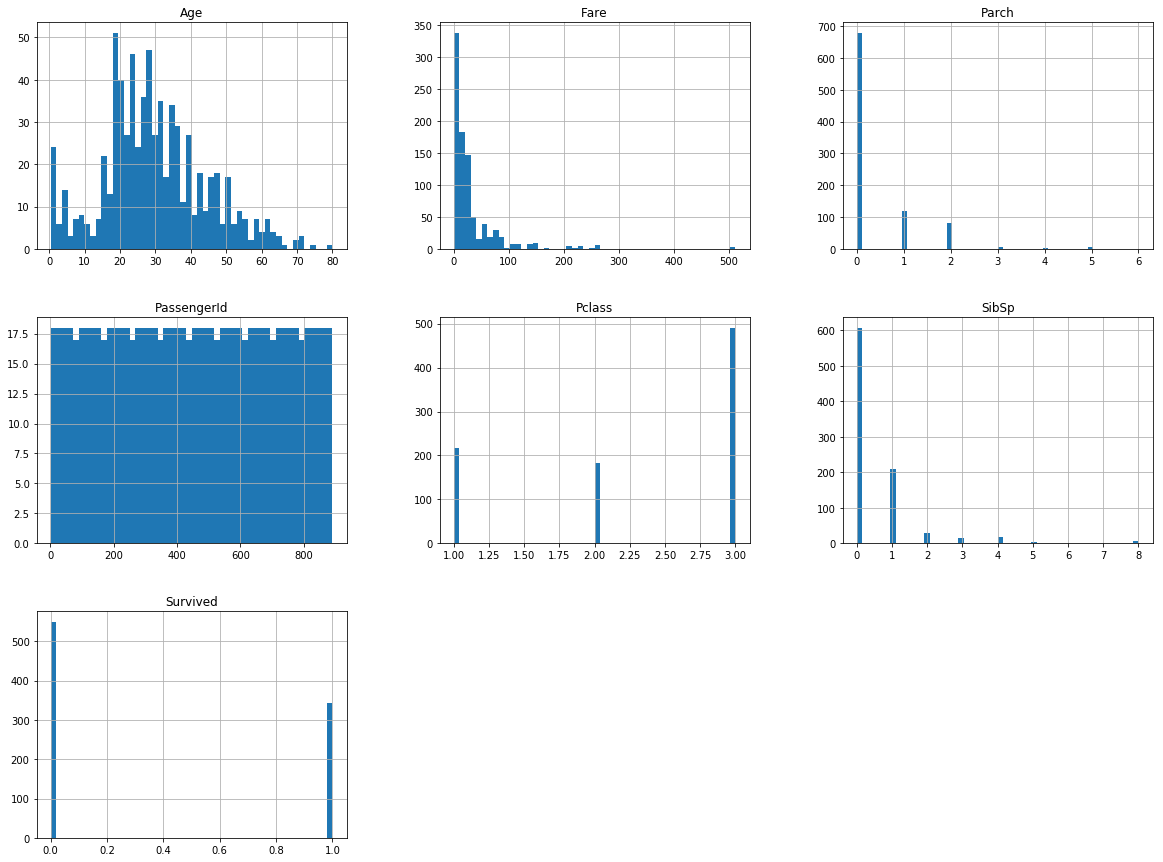

In [5]:
%matplotlib inline
titanic_train.hist(bins=50, figsize=(20,15))
plt.show()

Splitting out a title field from the name seems sensible and setting it's values to true/false
Flagging if a passenger had a Cabin or not - perhaps cabin type matters as well 
Trying to combine Parch and SibSp into a Family feature - saw someone else had done this and sounded sensible
Adding AgeBrackets and FareBrackets

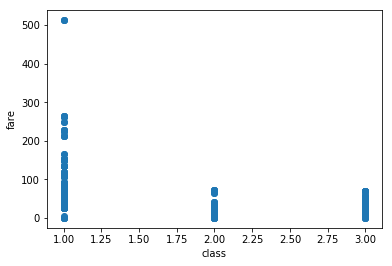

In [6]:
import matplotlib.pyplot
matplotlib.pyplot.scatter( titanic_train.Pclass, titanic_train.Fare )

matplotlib.pyplot.xlabel("class")
matplotlib.pyplot.ylabel("fare")
matplotlib.pyplot.show()

In [57]:
def TitleCategory(data):
    data["Title"] = "Other"
    data.loc[data["Name"].str.contains("Mr.", regex=False), "Title"] = "Mr"
    data.loc[data["Name"].str.contains("Mrs.", regex=False), "Title"] = "Mrs"
    data.loc[data["Name"].str.contains("Master.", regex=False), "Title"] = "Master"
    data.loc[data["Name"].str.contains("Miss.", regex=False), "Title"] = "Miss"
    data.loc[(data["Title"] == "Other") & (data["Sex"] == "male"), "Title"] = "Mr"
    data.loc[(data["Title"] == "Other") & (data["Sex"] == "female"), "Title"] = "Mrs"
    
def HasCabin(data):
    data["HasCabin"] = data["Cabin"]
    data["HasCabin"] = data["HasCabin"].fillna(value=0)
    data.loc[data["HasCabin"] != 0, "HasCabin"] = 1
    
def CombineFamily(data):
    data["Family"] = data["Parch"] + data["SibSp"]
    
def AloneFlag(data):
    data["Alone"] = 1
    data.loc[data["Family"] > 0, "Alone"] = 0
    
def CabinType(data):
    data["CabinLetter"] = data["Cabin"].str[0]
    
def AgeBracketsCategory(data):
    data["AgeBracket"] = ""
    data.loc[data["Age"] < 2, "AgeBracket"] = "<2"
    data.loc[(data["Age"] >= 2) & (data["Age"] < 7), "AgeBracket"] = "<7"
    data.loc[(data["Age"] >= 7) & (data["Age"] < 14), "AgeBracket"] = "<14"
    data.loc[(data["Age"] >= 14) & (data["Age"] < 20), "AgeBracket"] = "<20"
    data.loc[(data["Age"] >= 20) & (data["Age"] < 30), "AgeBracket"] = "<30"
    data.loc[(data["Age"] >= 30) & (data["Age"] < 40), "AgeBracket"] = "<40"
    data.loc[(data["Age"] >= 40) & (data["Age"] < 50), "AgeBracket"] = "<50"
    data.loc[(data["Age"] >= 50) & (data["Age"] < 60), "AgeBracket"] = "<60"
    data.loc[(data["Age"] >= 60) & (data["Age"] < 70), "AgeBracket"] = "<70"
    data.loc[data["Age"] >= 70, "AgeBracket"] = ">=70"
    
#Got fare details from: http://www.keyflux.com/titanic/facts.htm 
#However the brackets don't overlap well so making sure all values are covered
def FareBracketsCategory(data):
    data["TicketType"] = ""
    data.loc[data["Fare"] == 0, "TicketType"] = "NoFare"
    data.loc[(data["Fare"] > 0) & (data["Fare"] <= 8), "TicketType"] = "ThirdClass"
    data.loc[(data["Fare"] > 8) & (data["Fare"] <= 30), "TicketType"] = "SecondClass"
    data.loc[(data["Fare"] > 30) & (data["Fare"] < 870), "TicketType"] = "FirstClassBerth"
    #data.loc[(data["Fare"] > 30) & (data["Fare"] <= 75), "TicketType"] = "FirstClassBerthA" #Splitting as there appears to be less survival below 75 fare
    #data.loc[(data["Fare"] > 75) & (data["Fare"] < 870), "TicketType"] = "FirstClassBerthB"
    data.loc[data["Fare"] >= 870, "TicketType"] = "FirstClassParlourSuite" #Doesn't look like any data points hit this but leaving in anyway
    
def SetColumnDefaults(data):
    data.Embarked.fillna('S', inplace=True)
    data.loc[data["Embarked"] == "", "Embarked"] = "S"
    data.Cabin.fillna('Z', inplace=True)
    #data.Age.fillna((data["Age"].median()), inplace=True)
    for title in data.Title.unique():
        data.loc[data["Title"] == title, "Age"] = data.loc[data["Title"] == title, "Age"].fillna(data[titanic_analysis["Title"] == title].Age.mean())
    data.Fare.fillna((data["Fare"].mean()), inplace=True)
    
def FlagFamilyMembers(data):
    data["FatherOnly"] = 0
    data["MotherOnly"] = 0
    data.loc[(data["Parch"] > data["SibSp"]) & (data["Title"] == "Mr"), "FatherOnly"] = 1
    data.loc[(data["Parch"] > data["SibSp"]) & (data["Title"] == "Mrs"), "MotherOnly"] = 1
    data["HusbandOnly"] = 0
    data["WifeOnly"] = 0
    data.loc[(data["SibSp"] == 1) & (data["Parch"] == 0) & (data["Title"] == "Mr"), "HusbandOnly"] = 1
    data.loc[(data["SibSp"] == 1) & (data["Parch"] == 0) & (data["Title"] == "Mrs"), "WifeOnly"] = 1

def TicketCount(data):
    left = data[["PassengerId", "Ticket"]].groupby(['Ticket']).count()
    right = data[["PassengerId", "Ticket"]]
    data["TicketCount"] = pd.merge(left, right, on="Ticket")["PassengerId_x"]
    
def Outliers(data):
    #Looking at the data with titanic_analysis.Fare.sort_values() shows some extreme outliers so pulling into where the data groups better
    data.loc[data["Fare"] >= 263, "Fare"] = 263
    
def PrepData(data):
    Outliers(data)
    TitleCategory(data)
    SetColumnDefaults(data)
    HasCabin(data)
    CombineFamily(data)
    CabinType(data)
    AgeBracketsCategory(data)
    FareBracketsCategory(data)
    AloneFlag(data)
    FlagFamilyMembers(data)
    TicketCount(data)

In [59]:
from numbers import Number
def plot_survival_per_feature(data, feature, categorical = False):
    if not np.issubdtype(data[feature].dtype, np.number) or categorical == True:
        stacked = data.groupby([feature, 'Survived'])[feature].count().unstack('Survived').fillna(0)
        stacked.plot(kind='bar', stacked=True)
    else:
        grouped_by_survival = data[feature].groupby(data["Survived"])
        survival_per_feature = pd.DataFrame({"Survived": grouped_by_survival.get_group(1),
                                        "didnt_Survive": grouped_by_survival.get_group(0),
                                        })
        hist = survival_per_feature.plot.hist(bins=20, alpha=0.6, stacked = True)
        hist.set_xlabel(feature)
        plt.show()
        
def plot_survival_per_feature_grouping(data, feature, grouping):
    stacked = data.groupby([feature, grouping])[feature].count().unstack(grouping).fillna(0)
    stacked.plot(kind='bar', stacked=True)

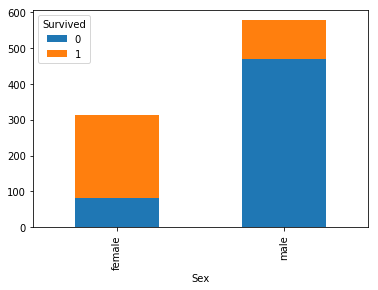

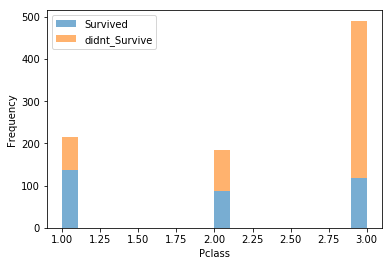

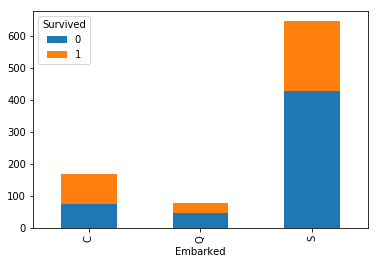

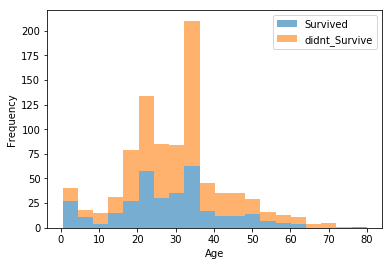

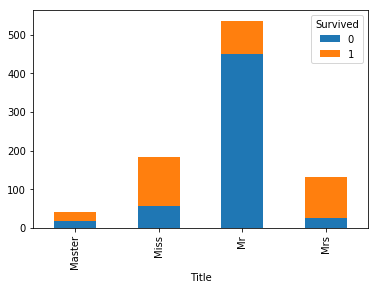

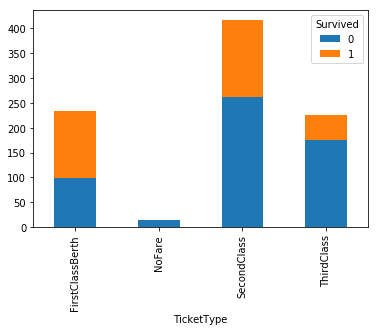

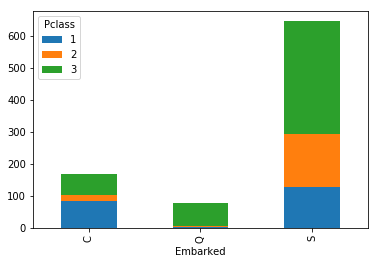

In [60]:
titanic_analysis = titanic_train.copy()
PrepData(titanic_analysis)
plot_survival_per_feature(titanic_analysis, "Sex")
plot_survival_per_feature(titanic_analysis, "Pclass")
plot_survival_per_feature(titanic_analysis, "Embarked")
plot_survival_per_feature(titanic_analysis, "Age")
plot_survival_per_feature(titanic_analysis, "Title")
plot_survival_per_feature(titanic_analysis, "TicketType")

plot_survival_per_feature_grouping(titanic_analysis, "Embarked", "Pclass")

,Survived
AgeBracket,
<14,0.375000
<2,0.857143
<20,0.397849
<30,0.386719
<40,0.332237
<50,0.382022
<60,0.416667
<7,0.621622
<70,0.315789


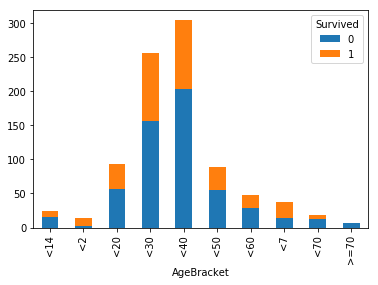

In [61]:
titanic_analysis["AgeBucket"] = titanic_analysis["Age"] // 10 * 10
titanic_analysis[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

plot_survival_per_feature(titanic_analysis, "AgeBracket")
titanic_analysis[["AgeBracket", "Survived"]].groupby(['AgeBracket']).mean()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'HasCabin',
       'Family', 'CabinLetter', 'AgeBracket', 'TicketType', 'Alone',
       'FatherOnly', 'MotherOnly', 'HusbandOnly', 'WifeOnly', 'TicketCount',
       'AgeBucket'],
      dtype='object')
          Survived    Pclass       Age     SibSp     Parch      Fare    Family
Survived  1.000000 -0.338481 -0.092097 -0.035322  0.081629  0.270984  0.016639
Pclass   -0.338481  1.000000 -0.339950  0.083081  0.018443 -0.600839  0.065997
Age      -0.092097 -0.339950  1.000000 -0.268344 -0.198676  0.094328 -0.282659
SibSp    -0.035322  0.083081 -0.268344  1.000000  0.414838  0.192617  0.890712
Parch     0.081629  0.018443 -0.198676  0.414838  1.000000  0.249556  0.783111
Fare      0.270984 -0.600839  0.094328  0.192617  0.249556  1.000000  0.256321
Family    0.016639  0.065997 -0.282659  0.890712  0.783111  0.256321  1.000000


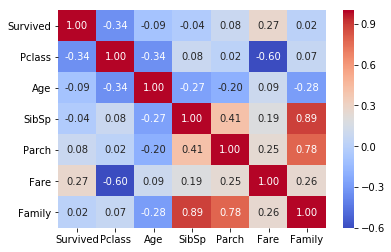

In [62]:
print(titanic_analysis.columns)
print (titanic_analysis[['Survived', 'Pclass','Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked', 'Title', 'Family']].corr())

sns.heatmap(titanic_analysis[['Survived', 'Pclass','Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked', 'Title', 'Family']].corr(), annot=True, fmt =".2f", cmap="coolwarm")

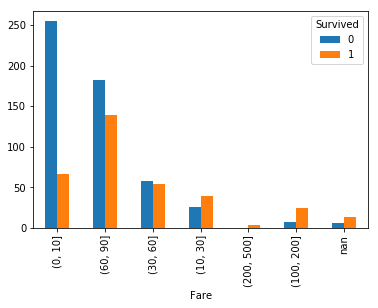

In [63]:
group = pd.cut(titanic_analysis.Fare, [0,10,30,60,90,100,200,500])
piv_fare = titanic_analysis.pivot_table(index=group, columns='Survived', values = 'Fare', aggfunc='count')
piv_fare.plot(kind='bar')

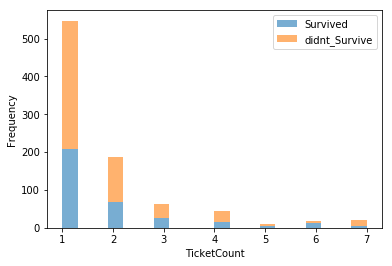

,Survived
TicketCount,
1,547
2,188
3,63
4,44
5,10
6,18
7,21


In [64]:
left = titanic_analysis[["PassengerId", "Ticket"]].groupby(['Ticket']).count()
right = titanic_analysis[["PassengerId", "Ticket"]]

titanic_analysis["TicketCount"] = pd.merge(left, right, on="Ticket")["PassengerId_x"]
plot_survival_per_feature(titanic_analysis, "TicketCount")
titanic_analysis[["TicketCount", "Survived"]].groupby(['TicketCount']).mean()
titanic_analysis[["TicketCount", "Survived"]].groupby(['TicketCount']).count()

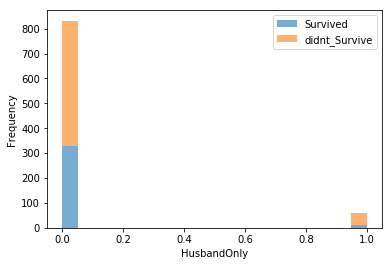

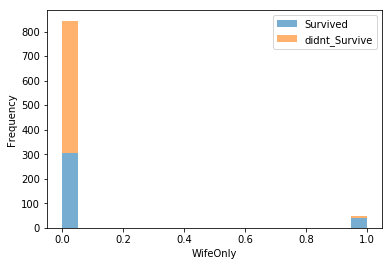

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,AgeBracket,TicketType,Alone,FatherOnly,MotherOnly,HusbandOnly,WifeOnly,TicketCount,AgeBucket,Surname


In [65]:
#How to join the data to look for family links?
titanic_analysis["Surname"] = titanic_analysis["Name"].str.split(",").str.get(0)
#print (titanic_analysis.head(10))
titanic_analysis.loc[(titanic_analysis["Surname"] == "Andersson") & (titanic_analysis["Alone"] == 0), :]
#How interesting it looks like ticket number can be used to identify families? Careful it is used for groups as well
#print(titanic_analysis.Ticket.value_counts())
#titanic_analysis.loc[((titanic_analysis["Parch"] > 1) | ((titanic_analysis["Parch"] > 0) & (titanic_analysis["SibSp"] == 0))) & ((titanic_analysis["Title"] == "Mr") | (titanic_analysis["Title"] == "Mrs")), :]

titanic_analysis["HusbandOnly"] = 0
titanic_analysis["WifeOnly"] = 0
titanic_analysis.loc[(titanic_analysis["SibSp"] == 1) & (titanic_analysis["Parch"] == 0) & (titanic_analysis["Title"] == "Mr"), "HusbandOnly"] = 1
titanic_analysis.loc[(titanic_analysis["SibSp"] == 1) & (titanic_analysis["Parch"] == 0) & (titanic_analysis["Title"] == "Mrs"), "WifeOnly"] = 1
titanic_analysis.head(10)

#Shows this might help - survival rates in husbandonly is very low and in wifeonly is very high. Assumption is husbands help their wives live!
plot_survival_per_feature(titanic_analysis, "HusbandOnly")
plot_survival_per_feature(titanic_analysis, "WifeOnly")

titanic_analysis.loc[titanic_analysis["Title"] == "Other",:] 

In [66]:
#How do I pinpoint parents!
titanic_analysis["FatherOnly"] = 0
titanic_analysis["MotherOnly"] = 0
titanic_analysis.loc[(titanic_analysis["Parch"] > titanic_analysis["SibSp"]) & (titanic_analysis["Title"] == "Mr"), "FatherOnly"] = 1
titanic_analysis.loc[(titanic_analysis["Parch"] > titanic_analysis["SibSp"]) & (titanic_analysis["Title"] == "Mrs"), "MotherOnly"] = 1

#plot_survival_per_feature(titanic_analysis, "FatherOnly")
#plot_survival_per_feature(titanic_analysis, "MotherOnly")

#titanic_analysis.loc[(titanic_analysis["Title"] == "Mrs") & (titanic_analysis["MotherOnly"] == 0) 
                     #& (titanic_analysis["WifeOnly"] == 0) & titanic_analysis["Family"] > 0, :]

pd.get_dummies(data = titanic_analysis, columns=["Title"])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,MotherOnly,HusbandOnly,WifeOnly,TicketCount,AgeBucket,Surname,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,...,0,1,0,3,20.0,Braund,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,...,0,0,1,3,30.0,Cumings,0,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,...,0,0,0,3,20.0,Heikkinen,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,...,0,0,1,3,30.0,Futrelle,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,...,0,0,0,3,30.0,Allen,0,0,1,0
5,6,0,3,"Moran, Mr. James",male,32.984412,0,0,330877,8.4583,...,0,0,0,3,30.0,Moran,0,0,1,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,...,0,0,0,2,50.0,McCarthy,0,0,1,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,...,0,0,0,2,0.0,Palsson,1,0,0,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,...,1,0,0,1,20.0,Johnson,0,0,0,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,...,0,0,1,1,10.0,Nasser,0,0,0,1


In [83]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

titanic_training = titanic_train.copy()

cat_attribs_orig = ["Sex","Embarked","Pclass","Title","TicketType","HasCabin","Alone","AgeBracket"
               ,"HusbandOnly","WifeOnly","FatherOnly","MotherOnly"]
cat_attribs = ["Sex","Embarked","Pclass","Title","HusbandOnly","WifeOnly","FatherOnly","MotherOnly"]
num_attribs = ["Age", "Fare", "Family", "TicketCount"]
print(num_attribs)
print(cat_attribs)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from future_encoders import OneHotEncoder
from sklearn.pipeline import FeatureUnion

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', MinMaxScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

train_labels = titanic_training["Survived"]
PrepData(titanic_training)

print(titanic_training.head(10))
print(titanic_training.info())
titanic_prepared = full_pipeline.fit_transform(titanic_training)

['Age', 'Fare', 'Family', 'TicketCount']
['Sex', 'Embarked', 'Pclass', 'Title', 'HusbandOnly', 'WifeOnly', 'FatherOnly', 'MotherOnly']
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex        Age  \
0                            Braund, Mr. Owen Harris    male  22.000000   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.000000   
2                             Heikkinen, Miss. Laina  female  26.000000   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.000000   
4                           Allen, Mr. William Henry    male  35.000000   
5                 

In [84]:
titanic_prepared[0:5]

array([[0.27117366, 0.02756654, 0.1       , 0.33333333, 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        ],
       [0.4722292 , 0.27103916, 0.1       , 0.33333333, 1.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 1.        , 0.        , 0.        , 1.        ,
        1.        , 0.        , 1.        , 0.        ],
       [0.32143755, 0.03013308, 0.        , 0.33333333, 1.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        ],
       [0.434

In [85]:
titanic_training[0:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Family,CabinLetter,AgeBracket,TicketType,Alone,FatherOnly,MotherOnly,HusbandOnly,WifeOnly,TicketCount
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,Z,<30,ThirdClass,0,0,0,1,0,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,C,<40,FirstClassBerth,0,0,0,0,1,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,Z,<30,ThirdClass,1,0,0,0,0,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,C,<40,FirstClassBerth,0,0,0,0,1,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,Z,<40,SecondClass,1,0,0,0,0,3


In [86]:
#Using iris example as a way of throwing a few algorithms at the issue and see how they perform
from pandas.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
# Test options and evaluation metric
seed = 42
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SGD', SGDClassifier()))
models.append(('SVC', SVC()))
models.append(('RF', RandomForestClassifier()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, titanic_prepared, train_labels, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.829413 (0.036813)
LDA: 0.826067 (0.044027)
KNN: 0.803645 (0.029803)
CART: 0.789076 (0.056429)
NB: 0.802497 (0.047054)
SGD: 0.790187 (0.045687)
SVC: 0.796879 (0.037619)
RF: 0.810375 (0.032765)


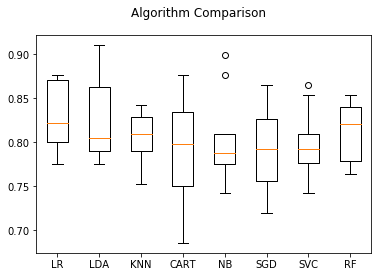

In [87]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From this brief comparison it looks like LR, LDA, KNN, SVM and RF are ok. However with this type of problem a confusion matrix is often useful to see how the precision and recall tradeoff is going. 
The top left  are true  negatives (survived = 0, pred_survived = 0)
The top right are false positives (survived = 0, pred_survived = 1)
Bottom left   are false negatives (survived = 1, pred_survived = 0) 
Bottom right  are true  postivies (survived = 1, pred_survived = 1)

In [75]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

def ConfusionMatrixPrecisionRecall(model, training_data, training_labels):
    cross_val_predictions = cross_val_predict(model, training_data, training_labels, cv=10)
    print(confusion_matrix(training_labels, cross_val_predictions))
    print("Precision:", precision_score(training_labels, cross_val_predictions))
    print("Recall:", recall_score(training_labels, cross_val_predictions))
    print("F1_Score:", f1_score(training_labels, cross_val_predictions))
    

for name, model in models:
    print ("Name:", name)
    print ("Model:", model)
    ConfusionMatrixPrecisionRecall(model, titanic_prepared, train_labels)
    print()
    
#ConfusionMatrixPrecisionRecall(forest_clf, titanic_prepared, train_labels)

Name: LR
Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
[[484  65]
 [ 90 252]]
Precision: 0.7949526813880127
Recall: 0.7368421052631579
F1_Score: 0.7647951441578148

Name: LDA
Model: LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
[[486  63]
 [ 89 253]]
Precision: 0.8006329113924051
Recall: 0.7397660818713451
F1_Score: 0.7689969604863223

Name: KNN
Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
[[470  79]
 [102 240]]
Precision: 0.7523510971786834
Recall: 0.7017543859649122
F1_Score: 0.7261724659606656

Name: CART
Model: DecisionTreeClassifier(class_wei

Kind of reinforces what was known but does show som interesting patterns. Originally I had trained with SGD, KNN and Random Forests but I switched to LR after looking at more algorithms and now I'll consider only the best 4 which are:
SVM/SVC
KNN
LR
LDA
Now into some hyperparameter turning to get the most out of the algorithms

In [77]:
from sklearn.model_selection import GridSearchCV

param_grid_knn = [
    {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11], 'weights': ["uniform","distance"]},
]

knn_clf = KNeighborsClassifier(n_jobs=-1)
grid_search_knn = GridSearchCV(knn_clf, param_grid_knn, cv=5)
grid_search_knn.fit(titanic_prepared, train_labels)

C:\Users\NickSandel\AppData\Local\conda\conda\envs\mlbook\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [76]:
param_grid_lr = [
    {'C': np.array(pd.Series([x * 0.01 for x in range(50, 70)])), 'solver' : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]},
]

lr_clf = LogisticRegression()
grid_search_lr = GridSearchCV(lr_clf, param_grid_lr, cv=5)
grid_search_lr.fit(titanic_prepared, train_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [78]:
param_grid_svc = [
    {'C': np.array(pd.Series([x * 0.01 for x in range(330,360)])), 'kernel' : ["linear", "poly", "rbf"]},
]

svc_clf = SVC()
grid_search_svc = GridSearchCV(svc_clf, param_grid_svc, cv=5)
grid_search_svc.fit(titanic_prepared, train_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['linear', 'poly', 'rbf'], 'C': array([3.3 , 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4 ,
       3.41, 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5 , 3.51,
       3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [79]:
param_grid_lda = [
    {'solver' : ["svd", "lsqr"],'n_components': np.array(pd.Series([x for x in range(1,5)]))},
]

lda_clf = LinearDiscriminantAnalysis()
grid_search_lda = GridSearchCV(lda_clf, param_grid_lda, cv=5)
grid_search_lda.fit(titanic_prepared, train_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_components': array([1, 2, 3, 4], dtype=int64), 'solver': ['svd', 'lsqr']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [81]:
print(grid_search_knn.best_params_)
print(grid_search_knn.best_estimator_)

#cvres = grid_search_knn.cv_results_
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#    print(np.sqrt(mean_score), mean_score, params)

print(grid_search_lr.best_params_)
print(grid_search_lr.best_estimator_)

print(grid_search_svc.best_params_)
print(grid_search_svc.best_estimator_)

print(grid_search_lda.best_params_)
print(grid_search_lda.best_estimator_)

{'weights': 'uniform', 'n_neighbors': 10}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='uniform')
{'solver': 'newton-cg', 'C': 0.61}
LogisticRegression(C=0.61, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)
{'kernel': 'rbf', 'C': 3.54}
SVC(C=3.54, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
{'n_components': 1, 'solver': 'svd'}
LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)


In [49]:
#Searching harder for the right C value with SVC
param_grid_svc = [
    {'C': np.array(pd.Series([x * 0.01 for x in range(330,350)])), 'kernel' : ["rbf"]},
]

svc_clf = SVC()
grid_search_svc = GridSearchCV(svc_clf, param_grid_svc, cv=5)
grid_search_svc.fit(titanic_prepared, train_labels)

print(grid_search_svc.best_params_)
print(grid_search_svc.best_estimator_)

{'kernel': 'rbf', 'C': 3.48}
SVC(C=3.48, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


So now re-train the models and re-evaluate the confusion matrices

In [50]:
knn_clf_best_params = KNeighborsClassifier(n_jobs=-1, n_neighbors=7, weights='uniform')
knn_clf_best_params.fit(titanic_prepared, train_labels)
ConfusionMatrixPrecisionRecall(knn_clf_best_params, titanic_prepared, train_labels)

[[488  61]
 [ 98 244]]
Precision: 0.8
Recall: 0.7134502923976608
F1_Score: 0.7542503863987635


In [82]:
lr_clf_best_params = LogisticRegression(C=0.61, solver="newton-cg")
lr_clf_best_params.fit(titanic_prepared, train_labels)
ConfusionMatrixPrecisionRecall(lr_clf_best_params, titanic_prepared, train_labels)

[[484  65]
 [ 91 251]]
Precision: 0.7943037974683544
Recall: 0.7339181286549707
F1_Score: 0.7629179331306991


In [52]:
svc_clf_best_params = SVC(C=3.48, kernel='rbf')
svc_clf_best_params.fit(titanic_prepared, train_labels)
ConfusionMatrixPrecisionRecall(svc_clf_best_params, titanic_prepared, train_labels)

[[482  67]
 [ 92 250]]
Precision: 0.7886435331230284
Recall: 0.7309941520467836
F1_Score: 0.7587253414264037


In [53]:
lda_clf_best_params = LinearDiscriminantAnalysis(solver='svd', n_components=1)
lda_clf_best_params.fit(titanic_prepared, train_labels)
ConfusionMatrixPrecisionRecall(lda_clf_best_params, titanic_prepared, train_labels)

[[486  63]
 [ 91 251]]
Precision: 0.7993630573248408
Recall: 0.7339181286549707
F1_Score: 0.7652439024390244


SVC is still coming out on top so have a go with submitting that file

In [29]:
PrepData(titanic_test)
#titanic_test.Fare.fillna((titanic_test["Fare"].median()), inplace=True)
titanic_test.info()
titanic_test_prepared = full_pipeline.fit_transform(titanic_test)
print(titanic_test_prepared[0])
print(titanic_prepared[0])

print(list(num_attribs), cat_attribs)

test_predictions = svc_clf_best_params.predict(titanic_test_prepared)
titanic_test_output = [titanic_test, test_predictions]
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": test_predictions
    })
print(submission)
#submission.to_csv('titanic_predictions_SVC_C3p58_K_RBF_v2.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 23 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          418 non-null object
Embarked       418 non-null object
Title          418 non-null object
HasCabin       418 non-null int64
Family         418 non-null int64
CabinLetter    418 non-null object
AgeBracket     418 non-null object
TicketType     418 non-null object
Alone          418 non-null int64
FatherOnly     418 non-null int64
MotherOnly     418 non-null int64
HusbandOnly    418 non-null int64
WifeOnly       418 non-null int64
TicketCount    418 non-null int64
dtypes: float64(2), int64(12), object(9)
memory usage: 75.2+ KB
[ 0.33880133 -0.49840706 -0.5534426 

This got me 0.78947 and ranked 3117 on Kaggle out of ~9000 so not bad! This is after much messing about which is hidden in other files. Next steps would be to revisit the data preparation phase and look more closely at what can be done there. For instance there were a large number of missing ages and doing median on them all doesn't feel right. Should instead split by title or something to get a better estimate for the missing values. My aim is 80% or better so I'm not done with this one yet! It's been very useful for learning key parts about data preparation and model selection/tuning. I need to understand more about the anyalysis phase and how to derive new fields/values in a better way.

Added age range blanks filling logic to use title to better predict and using median got 0.79425 which ranked 2131

Changing median on Title usage to mean showed a different setup for SVC and a slight increase in recall for a reduction in precision. Submitting this got me 0.78947 so reverting back to median
Corrected use of C value and it showed no difference on submission! 0.79425 still top score

So next steps:
- Look closer at the scaling as it really does seem to affect things. Maybe turn family into a binary attribute instead.
- Look at name to see if linking family members gleans anything - perhaps husbands died where the wife was on board? Or fathers? Or mothers?
- Look at ticket number - dismissed currently but could be something to gained if it can be cleaned up and used to determine location or something
- Try removing some parameters?

In [30]:
#The number of survived values is not even
print(titanic_training.Survived.value_counts())
print(549-342) #207 so should add 207 survived records back into the dataset?
print("Dead percentage:", 549/(549+342) * 100)
print("Survived percentage:", 342/(549+342) * 100)

X = titanic_prepared
y = train_labels
import imblearn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

print(X_resampled.size)

0    549
1    342
Name: Survived, dtype: int64
207
Dead percentage: 61.61616161616161
Survived percentage: 38.38383838383838
45018


In [31]:
#Searching harder for the right C value with SVC
param_grid_svc = [
    {'C': np.array(pd.Series([x * 0.1 for x in range(10,80)])), 'kernel' : ["rbf"]},
]

svc_clf = SVC()
grid_search_svc = GridSearchCV(svc_clf, param_grid_svc, cv=5)
grid_search_svc.fit(X_resampled, y_resampled)

print(grid_search_svc.best_params_)
print(grid_search_svc.best_estimator_)

{'C': 2.5, 'kernel': 'rbf'}
SVC(C=2.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [32]:
svc_clf_best_params = SVC(C=7.8, kernel='rbf')
svc_clf_best_params.fit(X_resampled, y_resampled)
ConfusionMatrixPrecisionRecall(svc_clf_best_params, X_resampled, y_resampled)

[[453  96]
 [130 419]]
Precision: 0.8135922330097087
Recall: 0.7632058287795993
F1_Score: 0.7875939849624061


In [33]:
from collections import Counter
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

clf_smote = SVC().fit(X_resampled, y_resampled)
X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

clf_adasyn = SVC().fit(X_resampled, y_resampled)

[(0, 549), (1, 549)]
[(0, 549), (1, 524)]


In [34]:
ConfusionMatrixPrecisionRecall(clf_smote, X_resampled, y_resampled)
ConfusionMatrixPrecisionRecall(clf_adasyn, X_resampled, y_resampled)

[[434 115]
 [177 347]]
Precision: 0.7510822510822511
Recall: 0.6622137404580153
F1_Score: 0.7038539553752535
[[434 115]
 [177 347]]
Precision: 0.7510822510822511
Recall: 0.6622137404580153
F1_Score: 0.7038539553752535


In [35]:
X_resampled, y_resampled = ros.fit_resample(X, y)
#Using iris example as a way of throwing a few algorithms at the issue and see how they perform
from pandas.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
# Test options and evaluation metric
seed = 42
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SGD', SGDClassifier()))
models.append(('SVC', SVC()))
models.append(('RF', RandomForestClassifier()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_resampled, y_resampled, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.794112 (0.027882)
LDA: 0.787698 (0.037968)
KNN: 0.795054 (0.039631)
CART: 0.866322 (0.060784)
NB: 0.782210 (0.041970)
SGD: 0.692285 (0.127940)
SVC: 0.797648 (0.055839)
RF: 0.858999 (0.057104)


In [36]:
for name, model in models:
    print ("Name:", name)
    print ("Model:", model)
    ConfusionMatrixPrecisionRecall(model, X_resampled, y_resampled)
    print()

Name: LR
Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
[[445 104]
 [119 430]]
Precision: 0.8052434456928839
Recall: 0.7832422586520947
F1_Score: 0.7940904893813481

Name: LDA
Model: LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
[[458  91]
 [137 412]]
Precision: 0.8190854870775348
Recall: 0.7504553734061931
F1_Score: 0.7832699619771863

Name: KNN
Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
[[436 113]
 [114 435]]
Precision: 0.7937956204379562
Recall: 0.7923497267759563
F1_Score: 0.7930720145852325

Name: CART
Model: DecisionTreeClassifier(class_wei

In [37]:
param_grid_rf = [
    {'n_estimators': [1,10,20,30,40,50]}
]

rf_clf = RandomForestClassifier(n_jobs=-1)
grid_search_rf = GridSearchCV(rf_clf, param_grid_rf, cv=5)
grid_search_rf.fit(X_resampled, y_resampled)

print(grid_search_rf.best_params_)
print(grid_search_rf.best_estimator_)

{'n_estimators': 40}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [38]:
param_grid_cart = [
    {'splitter': ["best","random"], 'criterion': ["gini","entropy"]}
]

cart_clf = DecisionTreeClassifier()
grid_search_cart = GridSearchCV(cart_clf, param_grid_cart, cv=5)
grid_search_cart.fit(X_resampled, y_resampled)

print(grid_search_cart.best_params_)
print(grid_search_cart.best_estimator_)

{'splitter': 'random', 'criterion': 'entropy'}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')


In [39]:
rf_clf_best_params = RandomForestClassifier(n_estimators=20)
rf_clf_best_params.fit(X_resampled, y_resampled)
ConfusionMatrixPrecisionRecall(rf_clf_best_params, X_resampled, y_resampled)

cv_results = model_selection.cross_val_score(rf_clf_best_params, X_resampled, y_resampled, cv=5, scoring="accuracy")
msg = "%s: %f (%f)" % ("RF", cv_results.mean(), cv_results.std())
print(msg)

[[456  93]
 [ 49 500]]
Precision: 0.8431703204047217
Recall: 0.9107468123861566
F1_Score: 0.8756567425569177
RF: 0.872560 (0.044864)


In [40]:
cart_clf_best_params = DecisionTreeClassifier(criterion = 'entropy', splitter= 'best')
cart_clf_best_params.fit(X_resampled, y_resampled)
ConfusionMatrixPrecisionRecall(cart_clf, X_resampled, y_resampled)

cv_results = model_selection.cross_val_score(cart_clf_best_params, X_resampled, y_resampled, cv=5, scoring="accuracy")
msg = "%s: %f (%f)" % ("RF", cv_results.mean(), cv_results.std())
print(msg)

[[447 102]
 [ 57 492]]
Precision: 0.8282828282828283
Recall: 0.8961748633879781
F1_Score: 0.8608923884514436
RF: 0.847039 (0.029763)


In [41]:
PrepData(titanic_test)
#titanic_test.Fare.fillna((titanic_test["Fare"].median()), inplace=True)
titanic_test.info()
titanic_test_prepared = full_pipeline.fit_transform(titanic_test)
print(titanic_test_prepared[0])
print(titanic_prepared[0])

print(list(num_attribs), cat_attribs)

test_predictions = rf_clf_best_params.predict(titanic_test_prepared)
titanic_test_output = [titanic_test, test_predictions]
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": test_predictions
    })
print(submission)
#submission.to_csv('titanic_predictions_RF_NE20_OversampleROS.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 23 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          418 non-null object
Embarked       418 non-null object
Title          418 non-null object
HasCabin       418 non-null int64
Family         418 non-null int64
CabinLetter    418 non-null object
AgeBracket     418 non-null object
TicketType     418 non-null object
Alone          418 non-null int64
FatherOnly     418 non-null int64
MotherOnly     418 non-null int64
HusbandOnly    418 non-null int64
WifeOnly       418 non-null int64
TicketCount    418 non-null int64
dtypes: float64(2), int64(12), object(9)
memory usage: 75.2+ KB
[ 0.33880133 -0.49840706 -0.5534426 

Argh although this looked better it actually produced a worse result! Only got 0.72 but still I don't think the oversampling use can be dismissed altogether

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier()
adaboost_clf.fit(X,y)

ConfusionMatrixPrecisionRecall(adaboost_clf, X, y)

[[472  77]
 [ 84 258]]
Precision: 0.7701492537313432
Recall: 0.7543859649122807
F1_Score: 0.7621861152141802


In [63]:
param_grid_ada = [
    {'n_estimators': np.array(pd.Series([x * 2 for x in range(10,20)])), 'learning_rate': np.array(pd.Series([x * 0.001 for x in range(160,180)]))}
]

ada_clf = AdaBoostClassifier()
grid_search_ada = GridSearchCV(ada_clf, param_grid_ada, cv=5, verbose=1, n_jobs=-1)
grid_search_ada.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   14.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'learning_rate': array([0.16 , 0.161, 0.162, 0.163, 0.164, 0.165, 0.166, 0.167, 0.168,
       0.169, 0.17 , 0.171, 0.172, 0.173, 0.174, 0.175, 0.176, 0.177,
       0.178, 0.179]), 'n_estimators': array([20, 22, 24, 26, 28, 30, 32, 34, 36, 38], dtype=int64)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [64]:
print(np.array(pd.Series([x * 2 for x in range(10,20)])))
print(np.array(pd.Series([x * 0.001 for x in range(160,180)])))
print(grid_search_ada.best_params_)
print(grid_search_ada.best_estimator_)

[20 22 24 26 28 30 32 34 36 38]
[0.16  0.161 0.162 0.163 0.164 0.165 0.166 0.167 0.168 0.169 0.17  0.171
 0.172 0.173 0.174 0.175 0.176 0.177 0.178 0.179]
{'learning_rate': 0.169, 'n_estimators': 20}
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.169, n_estimators=20, random_state=None)


In [65]:
adaboost_clf = AdaBoostClassifier(n_estimators=20, learning_rate=0.169)
adaboost_clf.fit(X,y)

ConfusionMatrixPrecisionRecall(adaboost_clf, X, y)

[[492  57]
 [ 90 252]]
Precision: 0.8155339805825242
Recall: 0.7368421052631579
F1_Score: 0.7741935483870966
